In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py

In [33]:
!wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z = d.T[1]
mu = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z,"DMdata_SN":mu,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)


URL transformed to HTTPS due to an HSTS policy
--2022-01-31 18:08:05--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘SCPUnion2.1_mu_vs_z.txt.27’

SCPUnion2.1_mu_vs_z 100%[===================>]  33.10K   106KB/s    in 0.3s    

2022-01-31 18:08:07 (106 KB/s) - ‘SCPUnion2.1_mu_vs_z.txt.27’ saved [33899/33899]



In [34]:
!wget https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
cov_mat = np.genfromtxt('SCPUnion2.1_covmat_sys.txt')


--2022-01-31 18:08:07--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6037238 (5.8M) [text/plain]
Saving to: ‘SCPUnion2.1_covmat_sys.txt.6’

SCPUnion2.1_covmat_ 100%[===================>]   5.76M  1.08MB/s    in 11s     

2022-01-31 18:08:19 (553 KB/s) - ‘SCPUnion2.1_covmat_sys.txt.6’ saved [6037238/6037238]



MCMC for Omega_m, n,H0 for SN events

In [35]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
        return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+2])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()
mcmc_arr[0,2]= np.random.uniform()
#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,3]=lnl(mcmc_arr[0,0], mcmc_arr[0,1],mcmc_arr[0,2])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,3]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)
    h0_next=np.random.normal(mcmc_arr[i-1,2],sigma_n)
    lnl_next= lnl(omega_m_next,n_next,h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= h0_next
        mcmc_arr[i,3]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= h0_next
            mcmc_arr[i,3]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= mcmc_arr[i-1,2]
            mcmc_arr[i,3]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.10276410039593627
Estimated value of n = 0.5467626117516292
Estimated value of standard deviation of omega_m = 0.037880727182337086
Estimated value of standard deviation of  n = 0.22020178506143967
Estimated value of h0 = 0.6978226373306388
Estimated value of standard deviation of h0 = 0.00907279967424399
Acceptance ratio is 56.82  percent


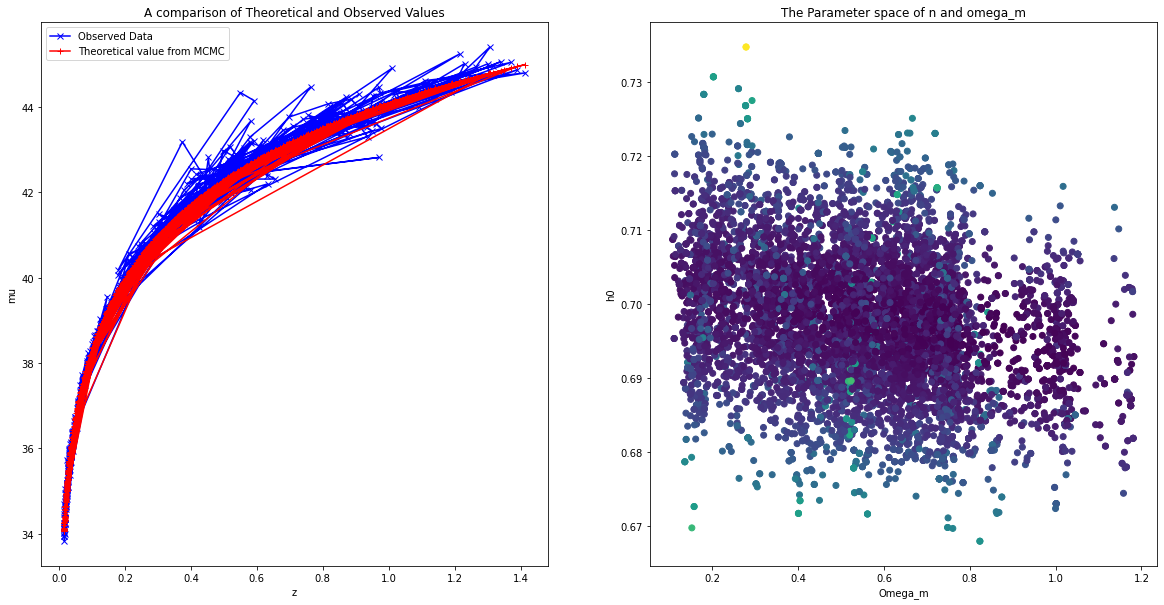

In [44]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= 100

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Estimated value of h0 = '+ str(np.mean(mcmc_arr[reject:sampl,2])))
print ('Estimated value of standard deviation of h0 = '+ str(np.std(mcmc_arr[reject:sampl,2])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,1], mcmc_arr[reject:,2],c = -mcmc_arr[reject:,3])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('h0')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]),np.mean(mcmc_arr[reject:,2]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 

Text(0.5, 0, 'steps')

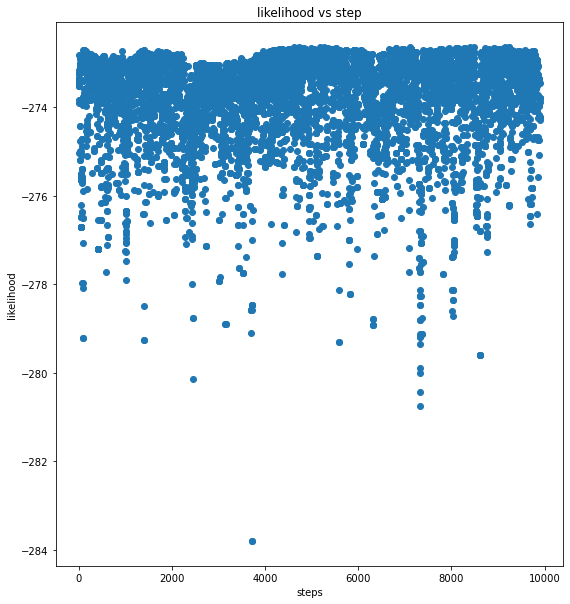

In [48]:
reject= 100
fig = plt.figure()
fig.set_size_inches(20,10)
b=np.linspace(1,sampl-reject,sampl-reject)
#Plot the samples
ax2 = fig.add_subplot(121)
ax2.scatter(b, mcmc_arr[reject:sampl,3])
plt.title("likelihood vs step")
plt.ylabel("likelihood")
plt.xlabel('steps')


MCMC for omega_m,n for SN events

In [10]:
#omega_m,n SN
#number of samples 
sampl= 10000
#number of pars
par = 2

inv_cov_mat= np.linalg.inv(cov_mat)
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
h0=69.8
#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n):
        m=5*log(D_l(z,omega_m,n),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n):
    if(omega_m<=0.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)

    lnl_next= lnl(omega_m_next,n_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.1497094474917166
Estimated value of n = 0.16278147735330611
Estimated value of standard deviation of omega_m = 0.05222026667068089
Estimated value of standard deviation of  n = 0.39065068082969434
Acceptance ratio is 86.26  percent


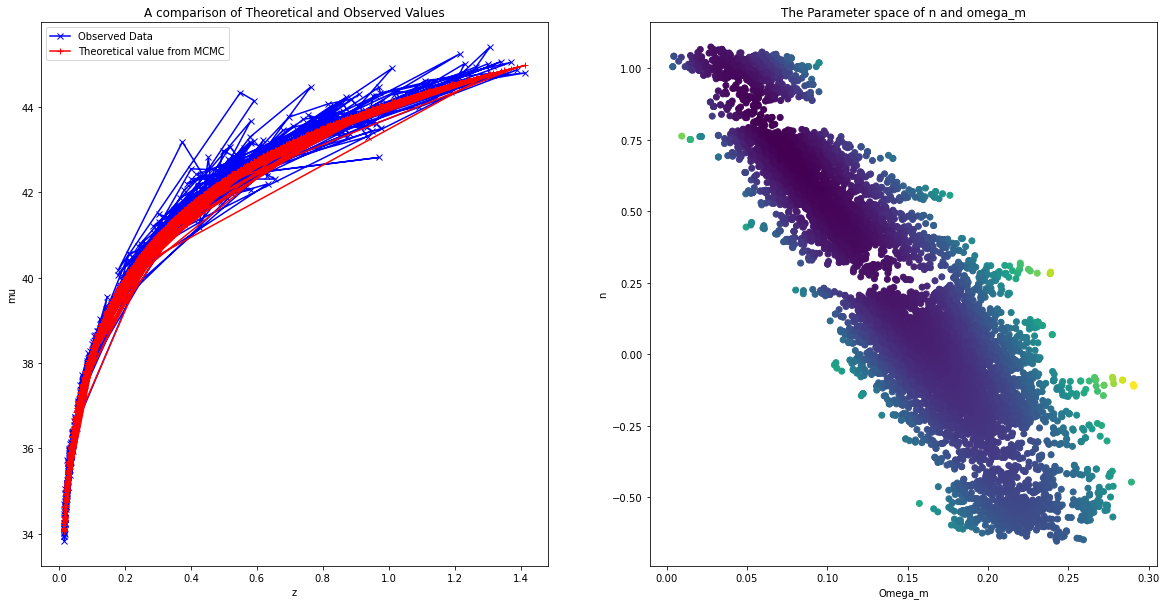

In [11]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('n')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 

MCMC for h0 for SN events

In [14]:
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
omega_m=0.30
n=0.27

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,h0):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,h0):
        m=5*log(D_l(z,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(h0):
    if(h0<=0.0 or h0>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],h0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    h0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

    lnl_next= lnl(h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= h0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= h0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of H0 = 0.6761100609310534
Estimated value of standard deviation of H0 = 0.006704407963773951
Acceptance ratio is 60.16  percent


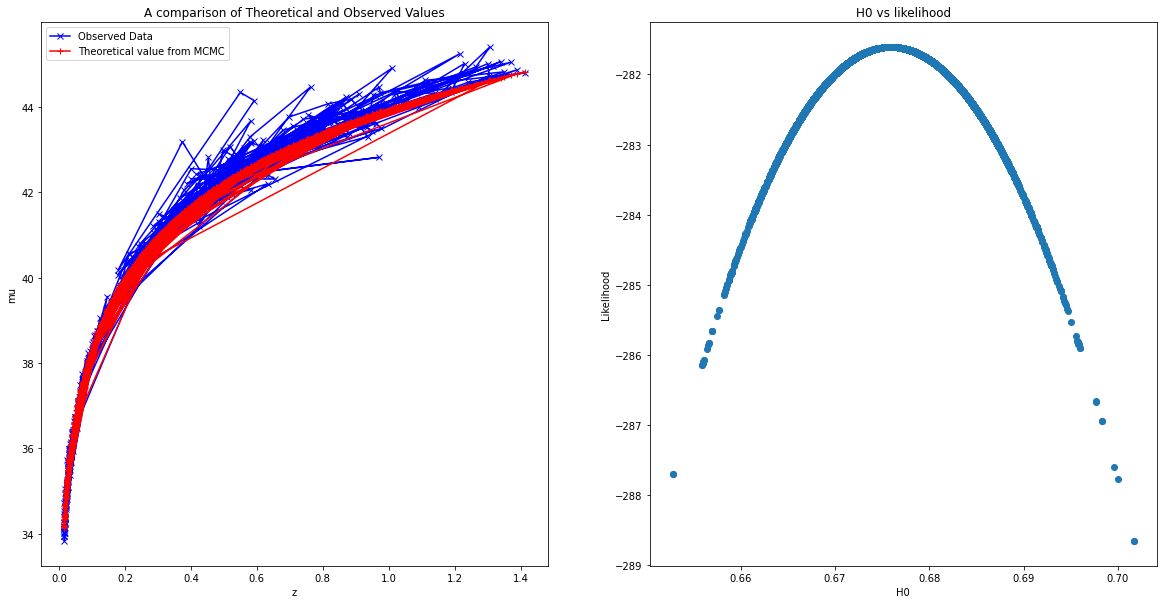

In [15]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of H0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of H0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("H0")
plt.ylabel('Likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("H0 vs likelihood")
plt.show() 

Collecting GW events

In [75]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/root/Github_Repos/VCG_GW/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow = pd.concat(dllowcollect)

a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
    
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

MCMC of omega_m, n for GW events

In [76]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
H0=69.8

#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(H0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n):
        m=5*log(D_l(z,omega_m,n),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n):
    if(omega_m<=0.0 or omega_m>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
        loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)

    lnl_next= lnl(omega_m_next,n_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.5082380701166181
Estimated value of n = 1.6998450169192567
Estimated value of standard deviation of omega_m = 0.2584338607909828
Estimated value of standard deviation of  n = 0.3888469688463259
Acceptance ratio is 99.55  percent


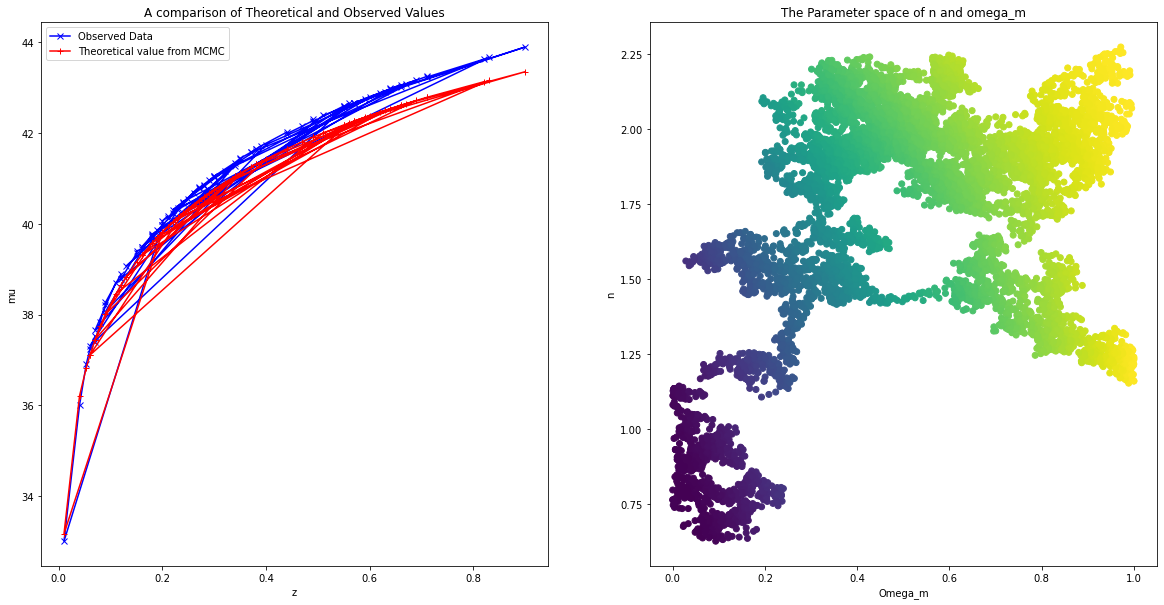

In [77]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('n')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 

In [ ]:
for x in range(100):
    lk=-np.exp(0.5*x**2/4)
i=np.linspace(0,100,100)    
plt.plot(i,lk)    

In [ ]:
for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
if dmu[0]>=0:
            loglikely= -0.5*np.dot(dmu,dmu)/np.dot(dmtoperr,dmtoperr)
if  dmu[0]<0:
            loglikely= -0.5*np.dot(dmu,dmu)/np.dot(dmbottomerr,dmbottomerr)
        

In [ ]:
#plt.style.use('seaborn-white')
n= np.linspace(-1.5,3,25)
omega_m =np.linspace(0.01,0.2,20)
np_array=np.asarray(col)
t1=np_array.reshape(20,25)
#fig,ax=plt.subplots(1,1)
levels = np.array([min(col)+2.3, min(col)+2*2.3, min(col)+3*2.3])
contours =plt.contourf(n,omega_m, t1,levels=levels, extend='min',cmap = 'gist_gray')
plt.xlabel('n')
plt.ylabel('$\Omega_m$')
plt.rcParams["figure.figsize"] = (5,5)
plt.title("$\chi^2$ Contours from SN measurement")
#plt.clabel(contours, inline=True, fontsize=8, colors='b')
#cp.set_clim(vmin=560,vmax=600)
#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.colorbar() # Add a colorbar to a plot
#plt.clim(0, 150) 

MCMC of H0 for GW events

In [71]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
omega_m=0.209
n=0.245

#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,h0):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,h0):
        m=5*log(D_l(z,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(h0):
    if(h0<=0.0 and h0>=1.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],h0)
        loglikely= -0.5*np.dot(dmu,dmu)/np.dot(sigma,sigma)
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    h0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

    lnl_next= lnl(h0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= h0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= h0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of H0 = 0.9450660899987475
Estimated value of standard deviation of H0 = 0.34535036914963835
Acceptance ratio is 99.29  percent


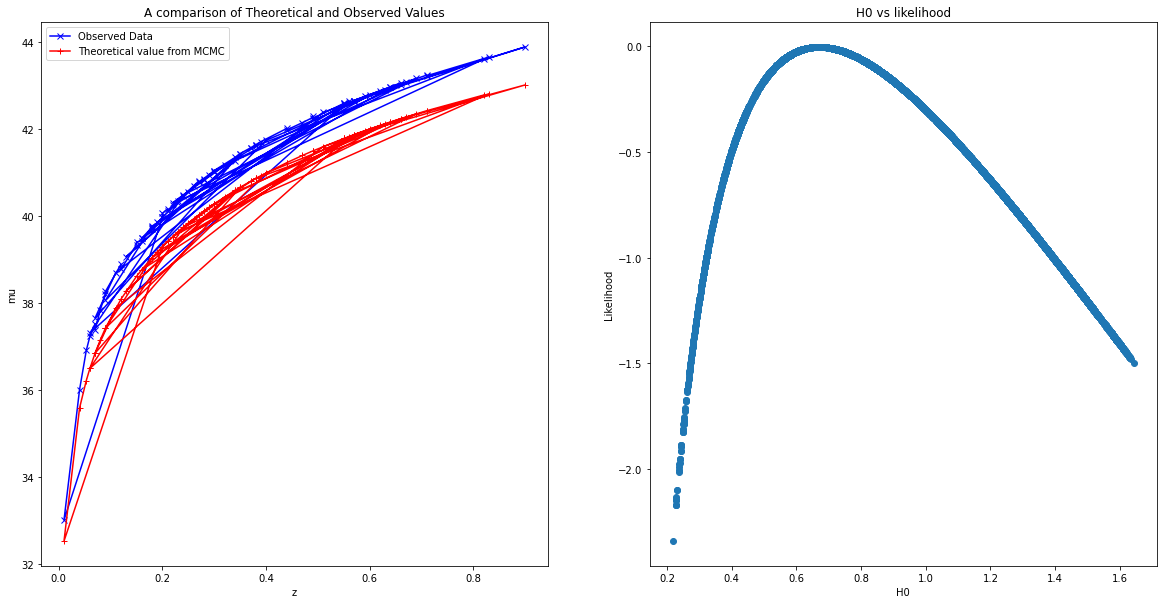

In [72]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= 100

print ('\n\n\nEstimated value of H0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of H0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("H0")
plt.ylabel('Likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("H0 vs likelihood")
plt.show() 

In [32]:
#standard model
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
h0=69.8
#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_r0,omega_m0):
    def int_func(x):
        return 1/(pow((1+x),2)*((1-omega_r0-omega_b0)/(1+x)**4+omega_r0+(omega_b0/(1+x))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_r0,omega_m0):
        m=5*log(D_l(z,omega_r0,omega_m0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_r0, omega_m0):
    if(omega_r0<=0.0 or omega_m0<=0.0 or omega_r0+omega_m0>=1):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_r0,omega_m0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_r0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    omega_m0_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)
       
    lnl_next= lnl(omega_r0_next,omega_m0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_r0_next
        mcmc_arr[i,1]= omega_m0_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_r0_next
            mcmc_arr[i,1]= omega_m0_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_r0 = 0.48681395138642825
Estimated value of omega_m0 = 0.2108615905512848
Estimated value of standard deviation of omega_r0 = 0.015873598932647625
Estimated value of standard deviation of  omega_m0 = 0.15013645268863085
Acceptance ratio is 78.76  percent


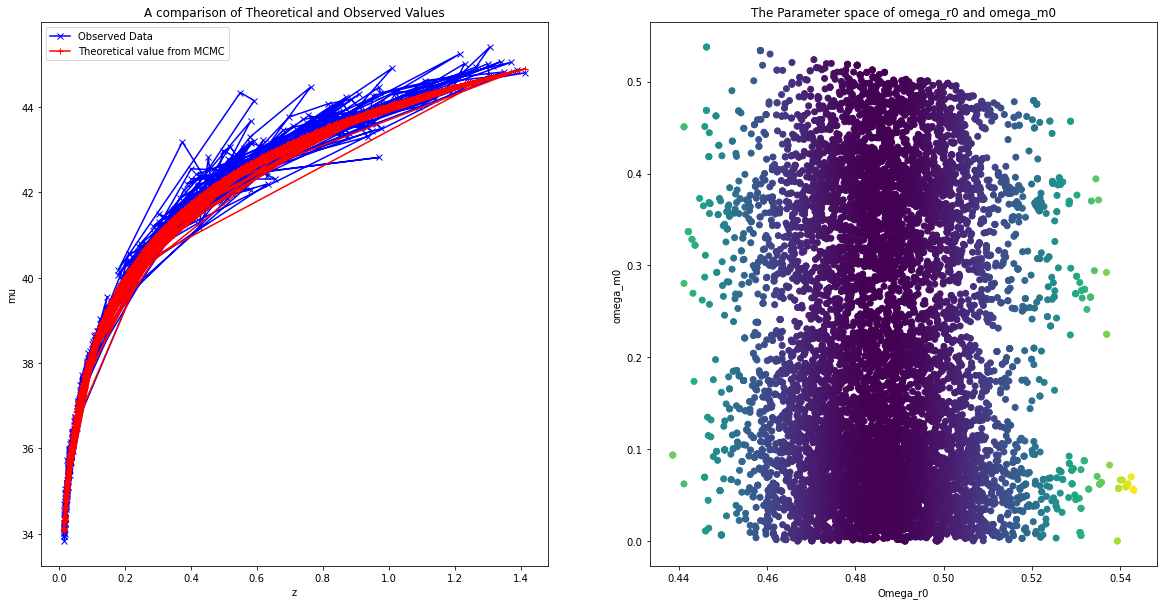

In [34]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_r0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of omega_m0 = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_r0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  omega_m0 = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0,1)
plt.xlabel("Omega_r0")
plt.ylabel('omega_m0')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of omega_r0 and omega_m0")
plt.show() 

In [46]:
#standard model with baryonic and dark energy
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
h0=69.8
#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m0):
    def int_func(x):
        return 1/(pow((1+x),2)*((1-omega_m0)/(1+x)**4+(omega_m0/(1+x)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m0):
        m=5*log(D_l(z,omega_m0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m0):
    if(omega_m0<=0.0 or omega_m0>=1):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m0)
        loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()


#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,1]=lnl(mcmc_arr[0,0])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,1]
    omega_m0_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)

       
    lnl_next= lnl(omega_m0_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m0_next
        mcmc_arr[i,1]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m0_next
            mcmc_arr[i,1]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m0 = 0.29540495392343624
Estimated value of standard deviation of  omega_m0 = 0.029665151601692887
Acceptance ratio is 89.43  percent


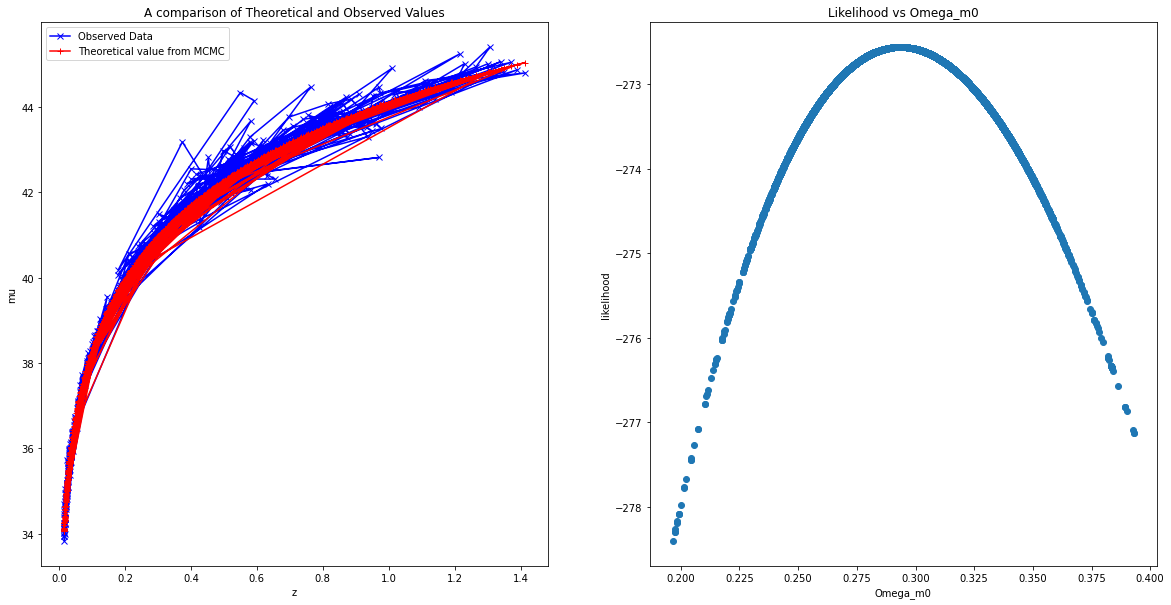

In [47]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m0 = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  omega_m0 = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1])
#plt.xlim(0.1,0.5)
#plt.ylim(0,1)
plt.xlabel("Omega_m0")
plt.ylabel('likelihood')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("Likelihood vs Omega_m0")
plt.show() 